This notebook is structured to read levels from an xml and perform sample calculations. We start off by installing any missing packages this notebook will need to fully run.

In [1]:
import sys, subprocess, pkg_resources
required = {'numpy','lvlspy','matplotlib'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed
if missing:
    subprocess.check_call([sys.executable, '-m','pip','install','--quiet',*missing])


import numpy as np
import lvlspy.level as lv
import lvlspy.spcoll as lc
import lvlspy.species as ls
import lvlspy.transition as lt
import matplotlib.pyplot as plt

Begin by downloading an example xml file, called, appropriately enough, *example.xml*, from [OSF](https://osf.io/3f59u/).  You may instead place or upload your own file and use it by commenting out the *curl* command.

In [2]:
!curl -o example.xml -J -L https://osf.io/w6ndg/download

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   459  100   459    0     0   1638      0 --:--:-- --:--:-- --:--:--  1719
100  2633  100  2633    0     0   2612      0  0:00:01  0:00:01 --:--:--     0


Begin by creating a new species collection.

In [3]:
new_coll = lc.SpColl()

Now ensure that the data in *example.xml* are appropriate to use with *lvlspy* by validating the XML file against the appropriate liblvls schema.

In [4]:
new_coll.validate('example.xml')

Now read the data into the species collection by updating the (empty) collection with data from the XML file.

In [5]:
new_coll.update_from_xml('example.xml')

Let's extract the species from the collection and set a temperature (in Kelvin)

In [6]:
sp = new_coll.get()['my_species']
T = 1.e+9 #K

From the stored properties in the xml, energies, Einstein A coefficients, and multiplicities, with the supplied temperature, we can calculate the rate matrix

In [7]:
rate_matrix = sp.compute_rate_matrix(T)

print('\nRate Matrix:\n')

for i in range(rate_matrix.shape[0]):
    for j in range(rate_matrix.shape[1]):
        print(i, j, rate_matrix[i, j])


Rate Matrix:

0 0 -99.61495634135446
0 1 145.63345239240016
0 2 110.887466284836
0 3 103.17422539160692
0 4 100.30298754492985
1 0 45.633452392400145
1 1 -363.7498904467478
1 2 145.63345239240016
1 3 110.887466284836
1 4 100.97340987674636
2 0 43.549865139344
2 1 182.53380956960058
2 2 -293.1266770152415
2 3 145.63345239240016
2 4 103.17422539160692
3 0 9.522676174820772
3 1 32.662398854508005
3 2 34.22508929430011
3 3 -370.5826103536791
3 4 110.887466284836
4 0 0.908962634789544
4 1 2.9202296302390773
4 2 2.380669043705193
4 3 10.887466284836
4 4 -415.33808909811916


The following exercises can be done by going through the steps of the other notebook without having to import an xml, but for the sake of flexing the power of the API, this is the route we chose. Since we have a rate matrix, we can now evolve our species with time at a fixed temperature. The governing differential equation is $\frac{dY}{dt} = \Lambda Y$. The integrator for this 5 coupled equations is the Newton-Raphson method, a full description can be found at [webnucleo.org](https://webnucleo.readthedocs.io/en/latest/jupyter_notebooks.html).

The following definition calculates the vector f in the equation $A\delta = -f$. The following contains the setup and loop for the Newton-Raphson solver. If you are unfamiliar with the method, it is fully described 

In [8]:
def f_vector(y_dt,y_i,A):
    return np.matmul(A,y_dt) - y_i

The following sets up and implements the Newton-Raphson method.

In [9]:
tol = 1.e-6 #convergence tolerance on newton raphson solver 
t = np.linspace(0,1,1000) #Time array
dt = t[1] - t[0] #Time step
y = np.array([1.,0,0,0,0]) #initial condition where only the ground state is populated

A = np.identity(5) - dt*rate_matrix #since the matrix is constant in time, we calculate it once for time/efficiency sake

#A good guess of a NR solver is the value of the system at current time  
y_dt = y
###########################
#for memory and processing consideration, it is best to setup the 2D array that will contain the solution of the system 
#throughout time
Y = np.empty((5,len(t)))
#setting the 1st column to the initial condition
Y[:,0] = y

for i in range(1,len(t)): 
    delta = np.ones(5)
    while max(delta) > tol:
        delta = np.linalg.solve(A,-f_vector(y_dt,y,A))
        y_dt = y_dt + delta
    #updating the 2D array after convergence
    Y[:,i] = y_dt
    #setting the new initial condition to the converged solution from previous step
    y = y_dt

Before plotting the solution, we can also compute the equilibrium solution beforehand and see if our evolved solutions will tend to them.

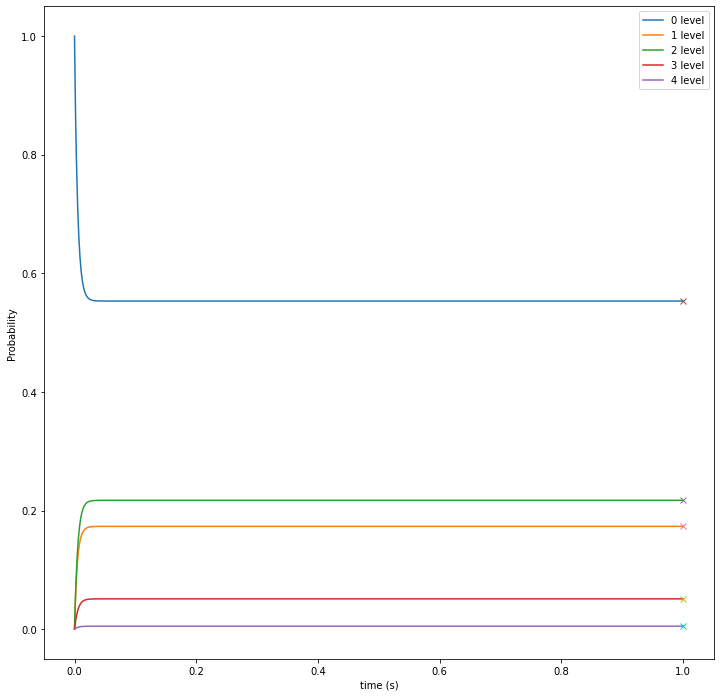

In [10]:
eq_probs = sp.compute_equilibrium_probabilities(T)

plt.figure(figsize=(12,12))
for i in range(len(sp.get_levels())):
    plt.plot(t,Y[i,:],label = str(i) + ' level')
        
for i in range(len(eq_probs)):
    plt.plot(1, eq_probs[i], 'x')
    
plt.xlabel('time (s)')
plt.ylabel('Probability')

plt.legend()
plt.show()

The fugacity evolution of each level can be calculated based on the attained solution

(0.0, 0.1)

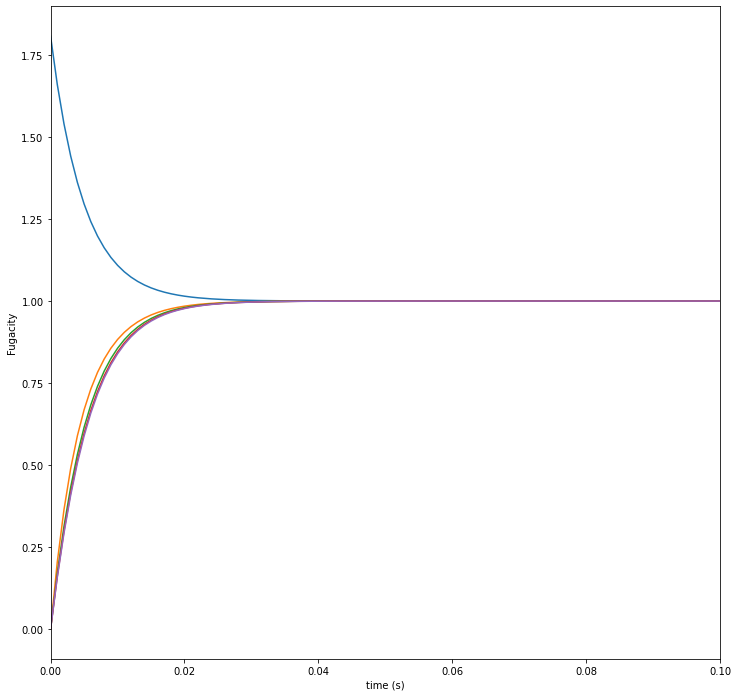

In [11]:
fugacities = np.empty((Y.shape[0], Y.shape[1]))

for i in range(len(sp.get_levels())):
    fugacities[i, :] = Y[i, :] / eq_probs[i]
    
plt.figure(figsize=(12,12))
for i in range(len(sp.get_levels())):
    plt.plot(t,fugacities[i,:],label = str(i) + ' level')
    
plt.xlabel('time (s)')
plt.ylabel('Fugacity')
    
plt.xlim([0,0.1])

As a final step to illustrate another *SpColl* method, output the data in the species collection to new files.  The first uses the default energy scale (*keV*) while the second specifically selects *eV* as the energy scale for the levels.

In [12]:
new_coll.write_to_xml("new_example.xml")

new_coll.write_to_xml("new_example_ev.xml", units = 'eV')

!cat new_example_ev.xml

<species_collection>
  <species name="my_species">
    <levels>
      <level>
        <properties>
          <energy units="eV">0.0</energy>
          <multiplicity>1</multiplicity>
        </properties>
      </level>
      <level>
        <properties>
          <energy units="eV">100000.0</energy>
          <multiplicity>1</multiplicity>
        </properties>
        <transitions>
          <transition>
            <to_energy units="eV">0.0</to_energy>
            <to_multiplicity>1</to_multiplicity>
            <a>100.0</a>
          </transition>
        </transitions>
      </level>
      <level>
        <properties>
          <energy units="eV">200000.0</energy>
          <multiplicity>4</multiplicity>
        </properties>
        <transitions>
          <transition>
            <to_energy units="eV">100000.0</to_energy>
            <to_multiplicity>1</to_multiplicity>
            <a>100.0</a>
          </transition>
          <transition>
            <to_energy units="eV">0.0</